In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
        host='localhost',
        user='root',
        password='your_password',
        database='ecommerce'
    )

# This creates the cursor object for the database connection db, 
# allowing you to interact with the database.
cur = db.cursor()

### 1. List all unique cities WHERE customers are located.


In [21]:
query = """ SELECT DISTINCT(customer_city) 
            FROM customers; """

# This method runs your SQL query 
cur.execute(query)

# This fetches all the rows returned by the query.
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Customer City"])
df.head(10)

,Customer City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


### 2. COUNT the number of orders placed in 2017.

In [20]:
query = """ SELECT COUNT(order_id) 
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2017; """

cur.execute(query)

data = cur.fetchall()
print("Total orders placed in 2017 are", data[0][0])

Total orders placed in 2017 are 45101


### 3. Find the total sales per category.

In [19]:
query = """ SELECT UPPER(products.product_category) category, 
                ROUND(SUM(payments.payment_value),2) sales
            FROM products
            JOIN order_items
            ON products.product_id = order_items.product_id
            JOIN payments
            ON payments.order_id = order_items.order_id
            GROUP BY category; """

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### 4. Calculate the percentage of orders that were paid in installments.

In [18]:
query = """ SELECT ((SUM(CASE 
            WHEN payment_installments >= 1 
            THEN 1 ELSE 0 END))/COUNT(*))*100 
            FROM payments; """
# payment_installments = 0 -> a person has paid no installments
# payment_installments = 1 -> a person has paid 1 installment
# hence, 1 is included

cur.execute(query)

data = cur.fetchall()

print("The percentage of orders that were paid in installments is", data[0][0])

The percentage of orders that were paid in installments is 99.9981


### 5. COUNT the number of customers FROM each state. 

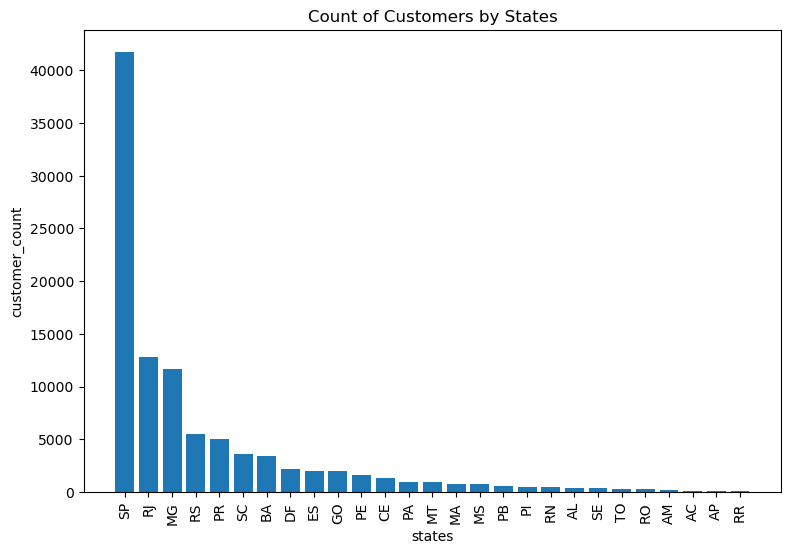

In [17]:
query = """ SELECT customer_state ,COUNT(customer_id)
            FROM customers 
            GROUP BY customer_state; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (9,6))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

### 6. Calculate the number of orders per month in 2018.

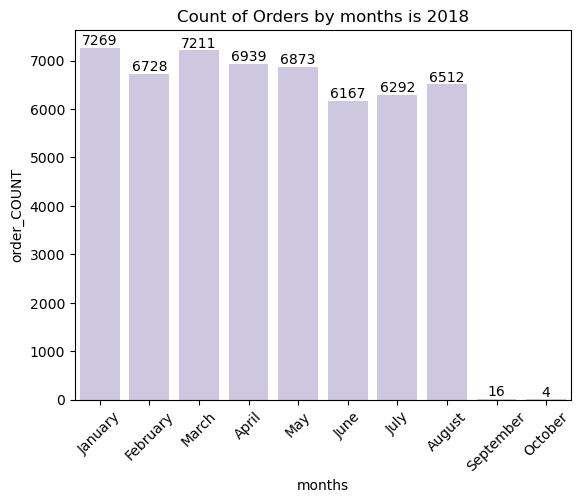

In [16]:
query = """ SELECT MONTHNAME(order_purchase_timestamp) months, 
                COUNT(order_id) order_COUNT
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2018
            GROUP BY months; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_COUNT"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_COUNT"], data = df, order = o, color = "#CBC3E3")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by months is 2018")

plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [15]:
query = """ WITH count_per_order AS 
                (SELECT orders.order_id, orders.customer_id, 
                COUNT(order_items.order_id) AS oc
                FROM orders 
                JOIN order_items
                ON orders.order_id = order_items.order_id
                GROUP BY orders.order_id, orders.customer_id)

            SELECT customers.customer_city, 
                ROUND(AVG(COUNT_per_order.oc),2) average_orders
            FROM customers 
            JOIN count_per_order
            ON customers.customer_id = count_per_order.customer_id
            GROUP BY customers.customer_city 
            ORDER BY average_orders DESC; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer City", "Average Products/Order"])
df.head(10)

,Customer City,Average Products/Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [23]:
query = """ SELECT UPPER(products.product_category) category, 
            ROUND((SUM(payments.payment_value)/
                    (SELECT SUM(payment_value) FROM payments))*100,2) sales_percentage
            FROM products 
            JOIN order_items 
            ON products.product_id = order_items.product_id
            JOIN payments 
            ON payments.order_id = order_items.order_id
            GROUP BY category ORDER BY sales_percentage DESC"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "Percentage Distribution"])
df.head(10)

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


### 9. Identify the correlation between product price and the number of times a product has been purchased.


In [28]:
cur = db.cursor()
query = """SELECT products.product_category, 
                COUNT(order_items.product_id),
                ROUND(avg(order_items.price),2)
            FROM products 
            JOIN order_items
            ON products.product_id = order_items.product_id
            GROUP BY products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "Order_Count", "Price"])

cor_coeff = df['Order_Count'].corr(df['Price'])
print(f"The correlation is {cor_coeff}")

The correlation is -0.10631514167157562


Correlation value suggests that there is **no dependency** between price and the count of orders

### 10. Calculate the total revenue generated by each seller, and rank them by revenue.


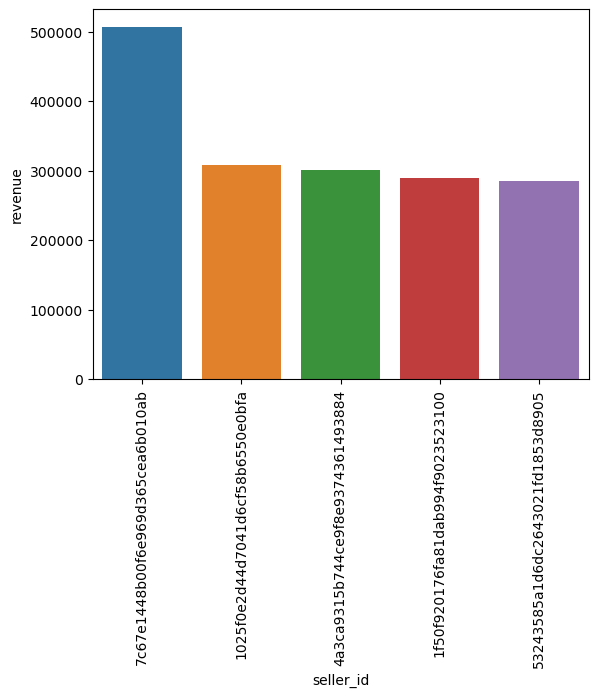

In [7]:
query = """ SELECT *, DENSE_RANK()  OVER(ORDER BY revenue DESC) AS rn 
            FROM (SELECT order_items.seller_id, 
            ROUND(SUM(payments.payment_value),2) revenue 
            FROM order_items 
            JOIN payments ON order_items.order_id = payments.order_id
            GROUP BY order_items.seller_id) AS a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.


In [11]:
query = """ SELECT customer_id, order_purchase_timestamp, payment,
                AVG(payment) OVER(PARTITION BY customer_id 
            ORDER BY order_purchase_timestamp
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW ) AS mov_avg
            FROM
                (SELECT orders.customer_id, 
                orders.order_purchase_timestamp, 
                payments.payment_value AS payment
                FROM payments JOIN orders
                ON payments.order_id = orders.order_id) AS a; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer_ID","Date_Time","Payment","Moving_Average"])
df


,Customer_ID,Date_Time,Payment,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### 12. Calculate the cumulative sales per month for each year.


In [17]:
query = """ SELECT years, months , payment, 
            SUM(payment) OVER(ORDER BY years, months) cumulative_sales 
            FROM
                (SELECT 
                YEAR(orders.order_purchase_timestamp) AS years,
                MONTH(orders.order_purchase_timestamp) AS months,
                ROUND(SUM(payments.payment_value),2) AS payment
                FROM orders 
                JOIN payments ON orders.order_id = payments.order_id
                GROUP BY years, months ORDER BY years, months) AS a; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year","Month","Payment","Cumulative_Sales"])
df

,Year,Month,Payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### 13. Calculate the year-over-year growth rate of total sales.

In [23]:
# yr_over_yr % growth = ((curr_yr_sales - prev_yr_sales)/prev_yr_sales)*100

query = """ WITH a AS
                (SELECT year(orders.order_purchase_timestamp) AS years,
                ROUND(SUM(payments.payment_value),2) AS payment 
                FROM orders 
                JOIN payments
                ON orders.order_id = payments.order_id
                GROUP BY years ORDER BY years)
                
            SELECT years, ROUND(((payment - lag(payment, 1) 
                            OVER(ORDER BY years))/
            LAG(payment, 1) OVER(ORDER BY years)) * 100, 3) FROM a; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yr_over_yr % growth"])
df

,years,yr_over_yr % growth
0,2016,NaN
1,2017,12112.704
2,2018,20.001


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [28]:
query = """ WITH a AS (SELECT customers.customer_id,
                        MIN(orders.order_purchase_timestamp) first_order
                        FROM customers 
                        JOIN orders
                        ON customers.customer_id = orders.customer_id
                        GROUP BY customers.customer_id),

                b AS (SELECT a.customer_id, 
                        COUNT(DISTINCT orders.order_purchase_timestamp) next_order
                FROM a 
                JOIN orders ON orders.customer_id = a.customer_id
                AND orders.order_purchase_timestamp > first_order
                AND orders.order_purchase_timestamp < 
                        DATE_ADD(first_order, INTERVAL 6 MONTH) 
                GROUP BY a.customer_id) 

                SELECT 100 * (COUNT(DISTINCT a.customer_id)/ 
                                COUNT(DISTINCT b.customer_id)) 
                FROM a LEFT JOIN b 
                ON a.customer_id = b.customer_id; """

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

No such customer found based on the data

### 15. Identify the top 3 customers who spent the most money in each year.

In [32]:
query = """ SELECT years, customer_id, payment, d_rank
            FROM
                (SELECT YEAR(orders.order_purchase_timestamp) years,
                orders.customer_id,
                SUM(payments.payment_value) payment,
                DENSE_RANK() 
                    OVER(PARTITION BY YEAR(orders.order_purchase_timestamp)
                        ORDER BY SUM(payments.payment_value) DESC) d_rank
                FROM orders JOIN payments 
                ON payments.order_id = orders.order_id
                GROUP BY year(orders.order_purchase_timestamp),
                    orders.customer_id) AS a
                WHERE d_rank <= 3; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
df

,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


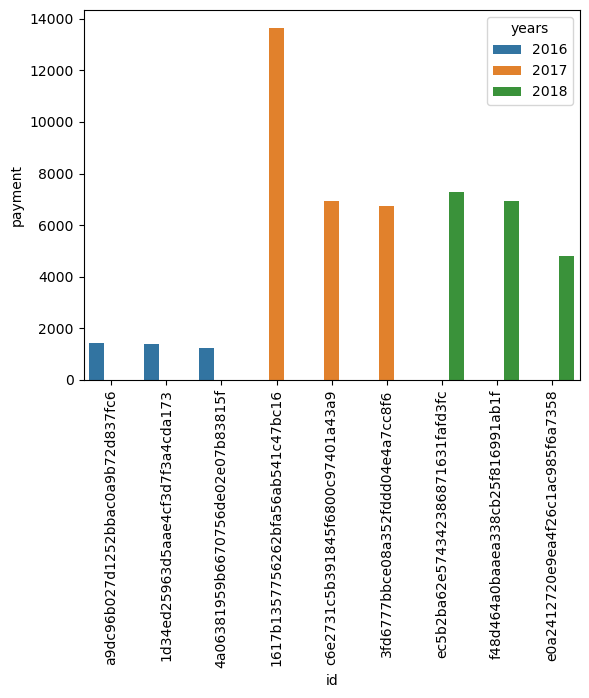

In [31]:
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()